<a href="https://colab.research.google.com/github/TolleDennis/basic-ml-course/blob/neural-networks/07_Neural_Network/Solution%207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7: Neural Network


Note: To run this notebook. You should change runtime type to GPU by: go to Runtime -> Change runtime type -> GPU

In lecture 7's video, we have shown you how to use Neural Network to classify handwritten digits on the MNIST dataset. In this notebook, we will go into the details. We also discover components that we have not talked about in the video.

<a href="https://colab.research.google.com/github/mpily/basic-ml-course/blob/Lecture_07/Solution7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [105]:
trainset = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())

Label:  4
Image shape:  torch.Size([1, 28, 28])


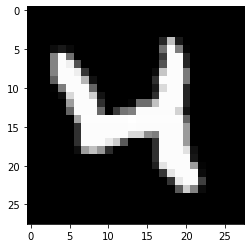

In [106]:
img, label = trainset[20]
print('Label: ', label)
print('Image shape: ', img.shape)
plt.imshow(img[0], cmap='gray')

In [107]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [108]:
a_layer = nn.Linear(2, 4)           # we create a layer
print("transposed weight: ", a_layer.weight.T)   # print the weight of the layer
print("bias: ", a_layer.bias)       # print the bias of the layer
input = torch.rand((3, 2))          # we create a dummy input
print('input: ', input)
# your code here      
output = torch.matmul(input,a_layer.weight.T) + a_layer.bias
print('output: ', output)

transposed weight:  tensor([[-0.6097,  0.3334,  0.0676, -0.6246],
        [-0.1401, -0.4020, -0.5802, -0.0434]], grad_fn=<PermuteBackward0>)
bias:  Parameter containing:
tensor([-0.3262, -0.6727,  0.1811,  0.6196], requires_grad=True)
input:  tensor([[0.5011, 0.2752],
        [0.0128, 0.0229],
        [0.2415, 0.3615]])
output:  tensor([[-0.6702, -0.6163,  0.0553,  0.2947],
        [-0.3372, -0.6777,  0.1687,  0.6107],
        [-0.5240, -0.7375, -0.0124,  0.4531]], grad_fn=<AddBackward0>)


In [109]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 120)  # first hidden layer
        self.fc2 = nn.Linear(120, 84)     # second hidden layer
        # your code here
        self.additional_layer = nn.Linear(84,84)
        self.fc3 = nn.Linear(84, 10)      # output layer

    def forward(self, x):
        x = torch.flatten(x, 1)   # flatten all dimensions except batch
        x = F.relu(self.fc1(x))   # compute output of first hidden layer + activation function
        x = F.relu(self.fc2(x))   # compute output of second hiddlen layer + activation function
        # your code here
        x = F.relu(self.additional_layer(x))
        x = self.fc3(x)           # compute output
        return x                  # return output

model = Net()

In [110]:
def softmax(z):
  #your code here
  output = z.exp() / z.exp().sum(-1).unsqueeze(-1)
  return output

In [111]:
def log_softmax(z):
  return softmax(z).log()

In [112]:
import numpy as np
def nll(preds, target):
  
  #initialize a prediction with zeros 0's with same shape with preds

  shape_pred = torch.zeros(preds.shape)
  for i in range(target.size()[0]):
    shape_pred[i][target[i]] = 1

  l = -preds * shape_pred
  return l

In [113]:
def cross_entropy_loss(z, target):
  
  return torch.sum(nll(log_softmax(z), target),axis=1).mean()

loss_function = nn.CrossEntropyLoss()
z = torch.rand((3, 10))

target = torch.tensor([0, 5, 9], dtype=torch.long)
print("cross_entropy_loss",cross_entropy_loss(z, target))
print("loss ",loss_function(z, target))

assert cross_entropy_loss(z, target) == loss_function(z, target), 'The two above task are not correct!'

cross_entropy_loss tensor(2.2027)
loss  tensor(2.2027)


In [114]:
def CEloss_with_l2(z, target, model, alpha):
  #initializing the first l1 CE loss
  CE_loss = cross_entropy_loss(z, target)
  # Your code here
  L2_loss = 0
  for param in model.parameters():
    L2_loss +=  torch.sum(param ** 2)
  loss = CE_loss + alpha * L2_loss
  return loss

CEloss_with_l2(torch.rand(2, 10), torch.tensor([2, 3], dtype=torch.long), model, 0.001)

tensor(2.5300, grad_fn=<AddBackward0>)

In [115]:
def CEloss_with_l1(z, target, model, alpha):
  # Your code here
  CE_loss = cross_entropy_loss(z,target)
  L1_loss = 0
  for param in model.parameters():
    L1_loss += torch.sum(torch.abs(param))
  loss = CE_loss + alpha * L1_loss
  return loss

CEloss_with_l1(torch.rand(2, 10), torch.tensor([2, 3], dtype=torch.long), model, 0.001)

tensor(5.0449, grad_fn=<AddBackward0>)

In [116]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [117]:
model.cuda()    # move model to GPU for faster computation in parallel
n_epochs = 15    # you should change to larger value
for epoch in range(n_epochs):
  print(f'Epoch {epoch}- Training... ')
  for batch_idx, (imgs, labels) in enumerate(tqdm(train_dataloader)):
    imgs = imgs.cuda()      # move images to GPU
    labels = labels.cuda()  # move labels to GPU
    optimizer.zero_grad()   # by default, Pytorch's optimizer retains gradient after apply Gradient Descent. We need to call this function to clear gradients explicitly.
    preds = model(imgs)     # pass batch of data through the model. 
    loss = loss_function(preds, labels)   # compute loss 
    loss.backward()         # compute gradient by running backpropgation algorithm
    optimizer.step()        # apply Gradient Descent
  
  # evaluate 
  print(f'Epoch {epoch}- Evaluating... ')
  total_correct = 0
  total = len(testset)
  for batch_indx, (imgs, labels) in enumerate(tqdm(test_dataloader)):
    imgs = imgs.cuda()
    labels = labels.cuda()
    preds = model(imgs).argmax(axis=-1)
    #loss = loss_function(preds, labels)
    #loss.backward()
    n_correct = torch.sum(preds == labels)
    total_correct += n_correct.item()
  
  print("Accuracy: ", total_correct/total)


Epoch 0- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 240.43it/s]


Epoch 0- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 193.90it/s]


Accuracy:  0.8904
Epoch 1- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 235.48it/s]


Epoch 1- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 197.19it/s]


Accuracy:  0.915
Epoch 2- Training... 


100%|██████████| 3750/3750 [00:16<00:00, 227.32it/s]


Epoch 2- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 198.18it/s]


Accuracy:  0.9479
Epoch 3- Training... 


100%|██████████| 3750/3750 [00:16<00:00, 229.93it/s]


Epoch 3- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 192.98it/s]


Accuracy:  0.9577
Epoch 4- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 235.02it/s]


Epoch 4- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 188.88it/s]


Accuracy:  0.9604
Epoch 5- Training... 


100%|██████████| 3750/3750 [00:16<00:00, 231.39it/s]


Epoch 5- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 195.28it/s]


Accuracy:  0.9653
Epoch 6- Training... 


100%|██████████| 3750/3750 [00:16<00:00, 233.32it/s]


Epoch 6- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 189.39it/s]


Accuracy:  0.9706
Epoch 7- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 235.67it/s]


Epoch 7- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 186.59it/s]


Accuracy:  0.9697
Epoch 8- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 235.99it/s]


Epoch 8- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 194.10it/s]


Accuracy:  0.9735
Epoch 9- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 237.78it/s]


Epoch 9- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 190.10it/s]


Accuracy:  0.9749
Epoch 10- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 235.75it/s]


Epoch 10- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 195.41it/s]


Accuracy:  0.9738
Epoch 11- Training... 


100%|██████████| 3750/3750 [00:16<00:00, 232.58it/s]


Epoch 11- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 193.29it/s]


Accuracy:  0.9755
Epoch 12- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 235.09it/s]


Epoch 12- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 195.53it/s]


Accuracy:  0.9742
Epoch 13- Training... 


100%|██████████| 3750/3750 [00:15<00:00, 238.49it/s]


Epoch 13- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 191.47it/s]


Accuracy:  0.9729
Epoch 14- Training... 


100%|██████████| 3750/3750 [00:16<00:00, 224.17it/s]


Epoch 14- Evaluating... 


100%|██████████| 313/313 [00:01<00:00, 195.25it/s]

Accuracy:  0.9745


Prediction: 7 - confident score: 99.99046325683594


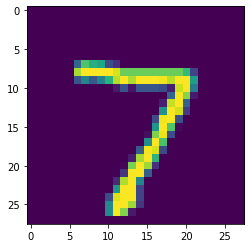

In [125]:
img, label = testset[0]   # you can change the index
# input_tensor = torch.tensor(img).cuda() # convert image to tensor to be able to pass through model, and model the image to GPU
input_tensor = img.clone().detach().cuda()  # to remove the torch.tensor will be deprecated error we use x.clone()
output = model(input_tensor)
# your code here
value = model(input_tensor).argmax(axis=-1)[0]
confident_score = softmax(model(input_tensor))[0].max() * 100
print(f"Prediction: {value} - confident score: {confident_score}")
plt.imshow(img[0])